In [1]:
import pandas as pd
import re
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from constants import *


## Датасет составлен из отзывов к моей любимой игре - dota2
## задача - выделение эмоций

In [2]:
def normalize_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"\d+", "[NUM]", text)

    return text

In [3]:
df = pd.read_csv('steam_reviews_570_russian.csv')
df = df.drop("review_id", axis=1)
df["sentiment"] = df["sentiment"].apply(lambda sentiment: 1 if sentiment == "positive" else 0)
df["review_text"] = df["review_text"].apply(normalize_text)
df

,sentiment,review_text
0,1,играю периодически с [NUM] года. игра приносит...
1,1,"эта игра - лучший симулятор потери всего, что ..."
2,1,зашёл в игру и немного поиграл после этого ко ...
3,0,зашел покатать в дота [NUM] спустя [NUM] лет п...
4,0,"игра говно, я просрал все, просрал жену, детей..."
...,...,...
4088,0,мать габена шалава
4089,0,на пару часов
4090,0,лучше бы уроки делал
4091,0,хуйня ебаная


In [4]:
X = df["review_text"]
y = df["sentiment"]
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

In [5]:

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
    pre_tokenizers.WhitespaceSplit(),
    pre_tokenizers.Punctuation()
])

trainer = trainers.BpeTrainer(
    vocab_size=10000,
    min_frequency=2,
    special_tokens=[
        "[PAD]",
        "[UNK]",
        "[NUM]"
    ]
)

tokenizer.train_from_iterator(X_train, trainer=trainer)

X_train_ids = [enc.ids for enc in tokenizer.encode_batch(X_train.tolist())]
X_val_ids  = [enc.ids for enc in tokenizer.encode_batch(X_val.tolist())]
X_test_ids  = [enc.ids for enc in tokenizer.encode_batch(X_test.tolist())]

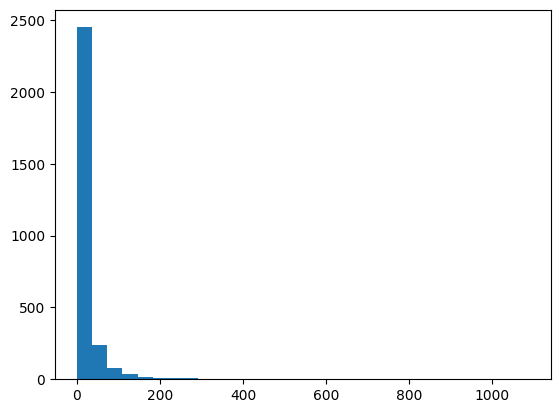

In [6]:
lens = []
for s in X_train_ids:
    lens.append(len(s))

plt.hist(lens, bins=30)
plt.show()

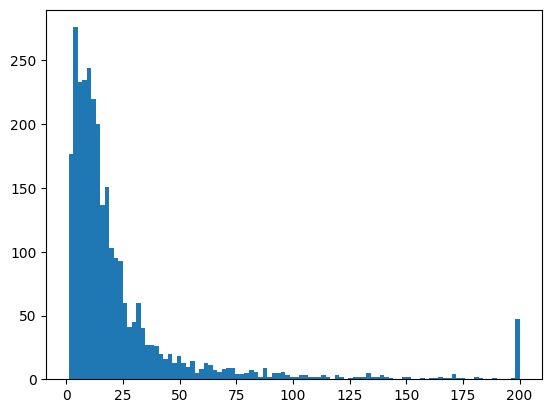

In [7]:
X_val_ids = [tokens[:200] if len(tokens) > 200 else tokens for tokens in X_val_ids]
X_test_ids = [tokens[:200] if len(tokens) > 200 else tokens for tokens in X_test_ids]
X_train_ids = [tokens[:200] if len(tokens) > 200 else tokens for tokens in X_train_ids]
lens = []
for s in X_train_ids:
    lens.append(len(s))

plt.hist(lens, bins=100)
plt.show()

In [8]:
vocab_size = tokenizer.get_vocab_size()

pad_idx = tokenizer.token_to_id("[PAD]")
unk_idx = tokenizer.token_to_id("[UNK]")

print("vocab_size:", vocab_size)
print("PAD =", pad_idx, "UNK =", unk_idx)

vocab_size: 8451
PAD = 0 UNK = 1


In [9]:
class TextDataset(Dataset):
    def __init__(self, X: pd.Series, y: pd.Series):
        self.texts = X
        self.labels = y.tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx: int):
        return self.texts[idx], self.labels[idx]

In [10]:
def collate_fn(batch):
    sequences, labels = zip(*batch)

    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)

    padded = torch.full((len(sequences), MAX_LEN), pad_idx, dtype=torch.long)

    for i, seq in enumerate(sequences):
        padded[i, :len(seq)] = torch.tensor(seq, dtype=torch.long)

    labels = torch.tensor(labels, dtype=torch.long)
    return padded, lengths, labels

In [11]:
class LSTMTextEmotionClassifier(nn.Module):
    def __init__(
            self,
            vocab_size: int,
            embed_dim: int,
            hidden_dim: int,
            num_classes: int,
            pad_idx: int,
            num_layers: int = 1,
            bidirectional: bool = False,
            dropout: float = 0.3,
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx,
        )

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

        self.fc = nn.Linear(
            hidden_dim * (2 if bidirectional else 1),
            num_classes,
        )

    def forward(self, x, lengths):
        embedded = self.embedding(x)

        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        _, (h_n, _) = self.lstm(packed)
        if self.bidirectional:
            h_forward = h_n[-2]
            h_backward = h_n[-1]
            h = torch.cat([h_forward, h_backward], dim=1)
        else:
            h = h_n[-1]

        h = self.dropout(h)
        logits = self.fc(h)

        return logits

In [12]:
train_ds = TextDataset(X_train_ids, y_train)
val_ds = TextDataset(X_val_ids, y_val)
test_ds = TextDataset(X_test_ids, y_test)


train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

In [13]:
device = torch.device("cuda")

model = LSTMTextEmotionClassifier(
    vocab_size=vocab_size,
    embed_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    pad_idx=pad_idx,
    num_layers=NUM_LAYERS,
    bidirectional=True,
    dropout=0.3,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


train_losses = []
train_acc = []
test_losses = []
test_acc = []

for epoch in range(NUM_EPOCHES):
    print("===== TRAIN =====")
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, lengths, target) in enumerate(train_loader):
        data, lengths, target = data.to(device), lengths.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data, lengths)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

        if batch_idx % LOG_PERIOD == (LOG_PERIOD - 1):
            train_losses.append(total_loss / LOG_PERIOD)
            train_acc.append(100 * correct / total)
            print(
                f"Epoch {epoch + 1}/{10}, Batch {batch_idx + 1}/{len(train_loader)}: Loss = {train_losses[-1]}, Acc = {train_acc[-1]}")
            total_loss = 0
            correct = 0
            total = 0

    print()
    print("===== VALIDATION =====")
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for data, lengths, target in val_loader:
            data, lengths, target = data.to(device), lengths.to(device), target.to(device)
            output = model(data, lengths)
            loss = criterion(output, target).item()
            total_loss += loss
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    test_losses.append(total_loss / len(val_loader))
    test_acc.append(100 * correct / total)

    print(f"Epoch {epoch + 1}/{10}: Test Loss = {test_losses[-1]}, Test Accuracy = {test_acc[-1]}")
    print()


===== TRAIN =====
Epoch 1/10, Batch 1/6: Loss = 0.7023992538452148, Acc = 48.046875
Epoch 1/10, Batch 2/6: Loss = 0.6928389668464661, Acc = 52.1484375
Epoch 1/10, Batch 3/6: Loss = 0.6948732733726501, Acc = 50.78125
Epoch 1/10, Batch 4/6: Loss = 0.6873860359191895, Acc = 54.1015625
Epoch 1/10, Batch 5/6: Loss = 0.6927117705345154, Acc = 53.90625
Epoch 1/10, Batch 6/6: Loss = 0.6854199767112732, Acc = 55.73770491803279

===== VALIDATION =====
Epoch 1/10: Test Loss = 0.6835266053676605, Test Accuracy = 59.28338762214984

===== TRAIN =====
Epoch 2/10, Batch 1/6: Loss = 0.6774351596832275, Acc = 61.5234375
Epoch 2/10, Batch 2/6: Loss = 0.6798695921897888, Acc = 59.9609375
Epoch 2/10, Batch 3/6: Loss = 0.6742056608200073, Acc = 60.7421875
Epoch 2/10, Batch 4/6: Loss = 0.6679209470748901, Acc = 61.71875
Epoch 2/10, Batch 5/6: Loss = 0.6641330718994141, Acc = 63.8671875
Epoch 2/10, Batch 6/6: Loss = 0.6724365949630737, Acc = 60.65573770491803

===== VALIDATION =====
Epoch 2/10: Test Loss = 0.

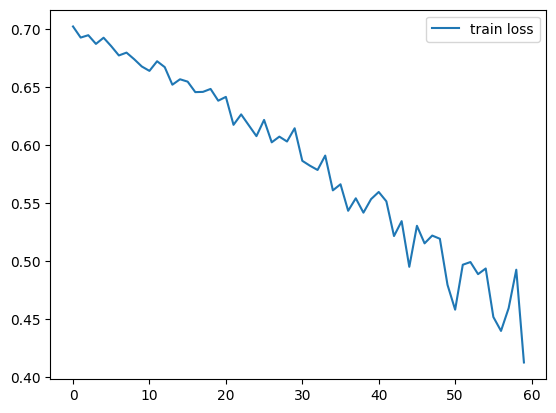

In [14]:
plt.plot(train_losses, label="train loss")
plt.legend()
plt.show()

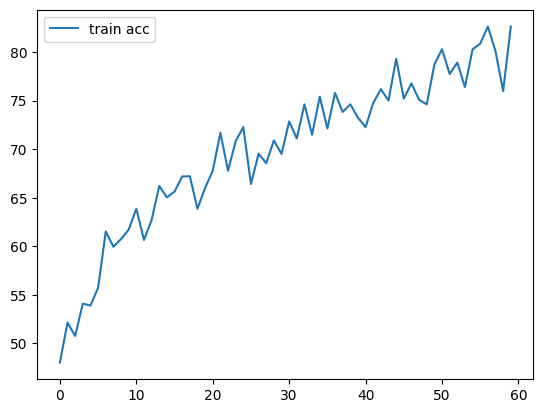

In [15]:
plt.plot(train_acc, label="train acc")
plt.legend()
plt.show()

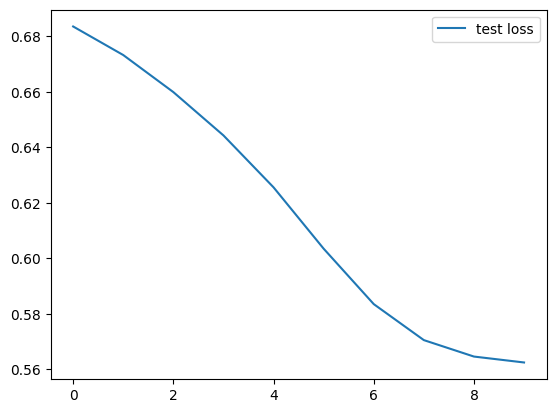

In [16]:
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

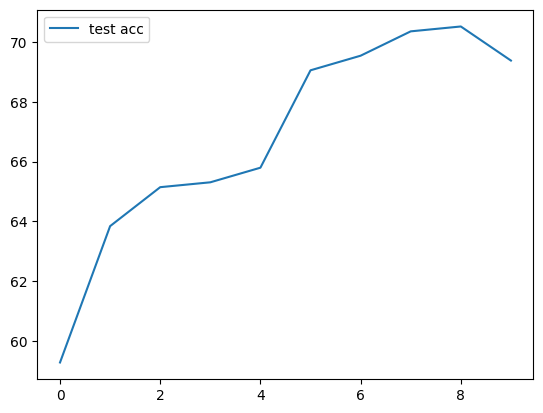

In [17]:
plt.plot(test_acc, label="test acc")
plt.legend()
plt.show()

In [18]:
def predict(text: str) -> str:
    model.eval()
    text = normalize_text(text)

    ids = tokenizer.encode(text).ids
    real_len = min(len(ids), MAX_LEN)

    if len(ids) < MAX_LEN:
        ids = ids + [pad_idx] * (MAX_LEN - len(ids))
    else:
        ids = ids[:MAX_LEN]

    text_tensor = torch.tensor([ids], dtype=torch.long).to(device)
    lengths = torch.tensor([real_len], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model(text_tensor, lengths)
        y_pred = logits.argmax(dim=1).item()

    return "positive" if y_pred == 1 else "negative"

In [19]:
print(predict("Не начинайте"))
print(predict("игра говно, слил на неё 2500 часов. никому не советую, только если хотите потерять своё драгоценное время."))
print(predict("игра говно, я просрал все, просрал жену, детей, и квартиру, так же был вьебан мид... короче не рекомендую"))
print(predict(
    "Эта игра - лучший симулятор потери всего, что у вас есть. За первые 10 минут матча вы узнаете, кто на самом деле ваш отец (спойлер: им окажется каждый из ваших тиммейтов), а ваша мать откроет собственное турне по родословным всех игроков на сервере.Система порядочности - это гениально. Она мягко намекает, что вам пора отдохнуть, последовательно отбирая голосовой чат, текстовый чат, а затем и право дышать в сторону монитора. Заболел? Не смог вынести матч на спине? Получи репорт за умышленное биологическое предательство. Я, например, стал дзен-буддистом. Уже не кричу, когда союзный Пудж съедает меня в ульте. Я медитирую.Игра бесплатная, но ваша психика, самооценка и вера в человечество - это премиум-контент, который вы плавно растеряете за первые 50 часов.Каждую игру - новый сюрприз! То ваш керри решит, что его истинное призвание — быть декорацией у фонтана, то вражеская команда так трогательно заботится о вашем моральном состоянии, что подробно расскажет, что вы делаете не так в жизни.Рекомендую для мазохистов, лингвистов (изучите 100500 новых способов сочетания мата и генеалогии) и тех, кто давно хотел, чтобы его жизнь контролировал невидимый алгоритм, считающий каждую вашу оплошность.В общем, игра - огонь! Просто настоящий костёр, на котором горят ваши нервные клетки. 10/10, иду покупать новую мышь и заодно записываться к психологу."))
print(predict("рекомендую"))
print(predict("рекомендую не играть в нее"))

negative
negative
positive
positive
positive
negative


In [20]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, lengths, target in test_loader:
        data, lengths, target = data.to(device), lengths.to(device), target.to(device)
        output = model(data, lengths)
        preds = torch.argmax(output, dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(target.cpu().tolist())

acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("TEST METRICS:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 score : {f1:.4f}")

TEST METRICS:
Accuracy : 0.7427
Precision: 0.7432
Recall   : 0.7427
F1 score : 0.7426
